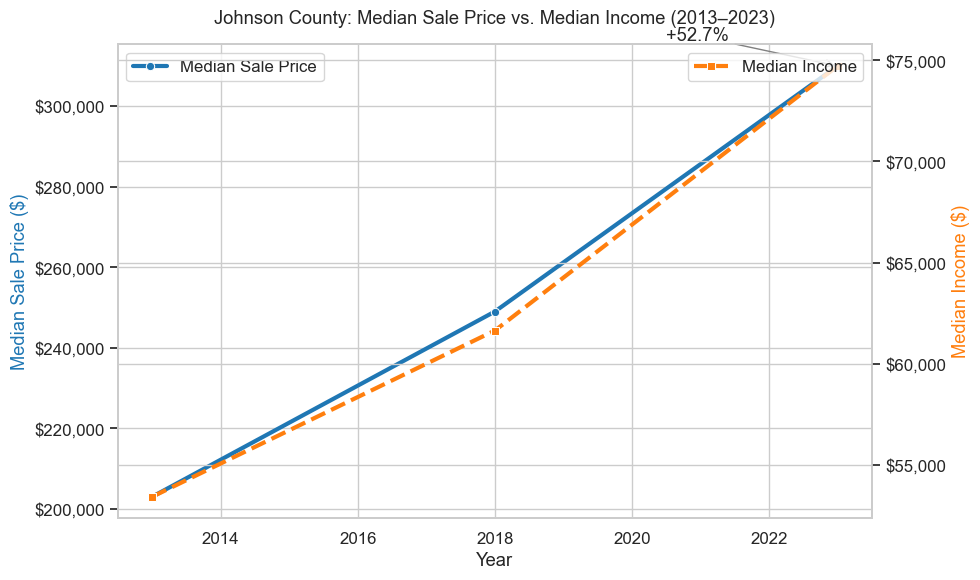

/var/folders/bn/w71p881s2l37kwdsrn6n574c0000gn/T/ipykernel_26345/4033645431.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/bn/w71p881s2l37kwdsrn6n574c0000gn/T/ipykernel_26345/4033645431.py:101: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Applications/anaconda3/envs/Class/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


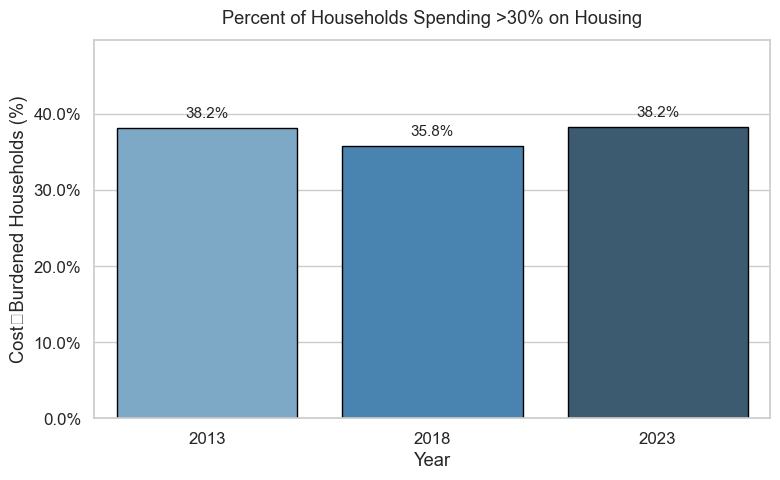

/var/folders/bn/w71p881s2l37kwdsrn6n574c0000gn/T/ipykernel_26345/4033645431.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


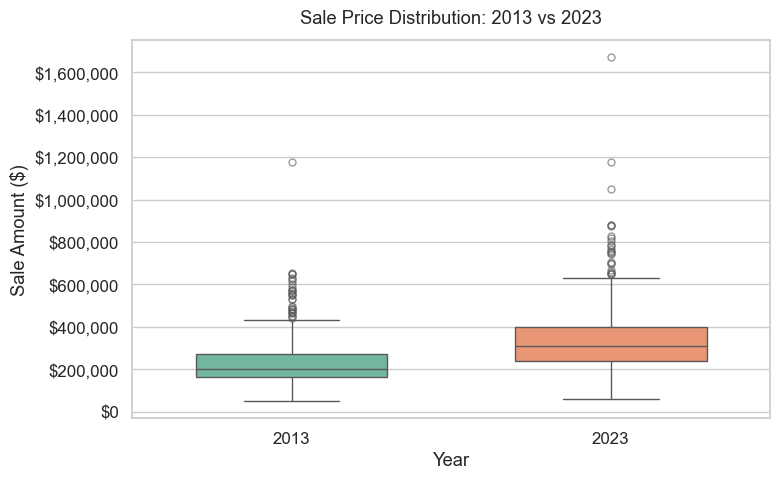

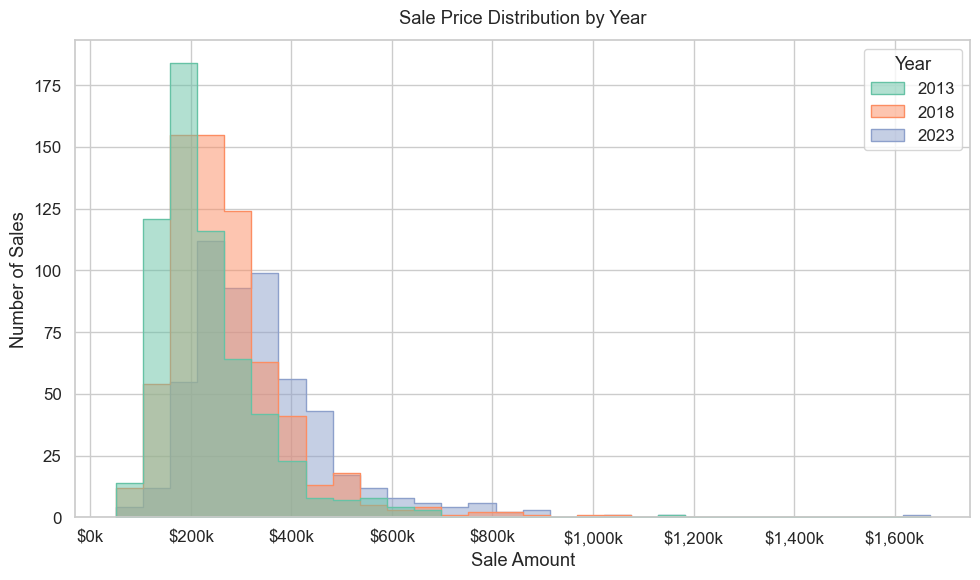

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import re
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

DATA_FILE = 'Combined, Cleaned Data/master_housing_plus_ACS.csv'

# Load & clean
df = pd.read_csv(DATA_FILE)
df['Sale Amount'] = (
    df['Sale Amount'].astype(str)
       .str.replace(r'[\$,]', '', regex=True)
       .str.replace(r'\*.*',   '', regex=True)
       .astype(float)
)
df['Year'] = df['Year'].astype(int)

# County‑level trend table
yearly = df.groupby('Year')['Sale Amount'] \
    .agg(Median_Sale_Price='median', Mean_Sale_Price='mean') \
    .reset_index()
acs = (
    df[['Year','Median_Income','Cost_Burden_Proportion']]
    .drop_duplicates()
    .rename(columns={'Cost_Burden_Proportion':'Cost_Burden'})
    .sort_values('Year')
)
trend_df = yearly.merge(acs, on='Year')

# Seaborn
sns.set_theme(style='whitegrid', palette='Set2', font_scale=1.1)

#  Graph #1: Dual‑Axis Line (Sale Price vs Income)
# ————————————————————————————————————————————————————————————————
fig, ax1 = plt.subplots(figsize=(10,6))

sns.lineplot(
    data=trend_df, x='Year', y='Median_Sale_Price',
    marker='o', linewidth=3, label='Median Sale Price',
    color='tab:blue', ax=ax1
)
ax2 = ax1.twinx()
sns.lineplot(
    data=trend_df, x='Year', y='Median_Income',
    marker='s', linewidth=3, linestyle='--', label='Median Income',
    color='tab:orange', ax=ax2
)

# annotate % change from 2013 to 2023
pct = (
    trend_df.loc[trend_df.Year==2023,'Median_Sale_Price'].iloc[0] /
    trend_df.loc[trend_df.Year==2013,'Median_Sale_Price'].iloc[0] - 1
) * 100
ax1.annotate(
    f'+{pct:.1f}%',
    xy=(2023, trend_df.Median_Sale_Price.iloc[-1]),
    xytext=(2020.5, trend_df.Median_Sale_Price.max()*1.02),
    arrowprops=dict(arrowstyle='->', color='gray')
)

# formatting
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Sale Price ($)', color='tab:blue')
ax2.set_ylabel('Median Income ($)', color='tab:orange')
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax1.set_title('Johnson County: Median Sale Price vs. Median Income (2013–2023)', pad=15)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

#  Graph #2: Cost‑Burden Bar Chart
# ————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(
    data=trend_df, x='Year', y='Cost_Burden',
    palette='Blues_d', edgecolor='black', ax=ax
)
ax.set_ylabel('Cost‑Burdened Households (%)')
ax.set_xlabel('Year')
ax.set_title('Percent of Households Spending >30% on Housing', pad=12)
ax.set_ylim(0, trend_df.Cost_Burden.max()*1.3)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))

# value labels
for bar in ax.patches:
    h = bar.get_height()
    ax.text(
        bar.get_x()+bar.get_width()/2, h+0.01,
        f'{h:.1%}', ha='center', va='bottom', fontsize=11
    )

plt.tight_layout()
plt.show()

#  Graph #3: Boxplot (2013 vs 2023)
# ————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(figsize=(8,5))

sns.boxplot(
    x='Year', y='Sale Amount', data=df[df.Year.isin([2013,2023])],
    palette=['#66c2a5','#fc8d62'], width=0.6,
    showfliers=True, flierprops={'marker':'o','alpha':0.6,'markersize':5},
    ax=ax
)
ax.set_title('Sale Price Distribution: 2013 vs 2023', pad=12)
ax.set_ylabel('Sale Amount ($)')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()
plt.show()

#  Graph #4: Overlapping Histogram (2013, 2018, 2023)
# ————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(
    data=df[df.Year.isin([2013,2018,2023])],
    x='Sale Amount', hue='Year',
    element='step', stat='count', common_norm=False,
    palette='Set2', alpha=0.5, bins=30,
    ax=ax
)

# format x‑axis with ticks every $200k
ax.xaxis.set_major_locator(ticker.MultipleLocator(200_000))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x,pos: f'${int(x/1000):,}k'
))
ax.set_xlabel('Sale Amount')
ax.set_ylabel('Number of Sales')
ax.set_title('Sale Price Distribution by Year', pad=12)
plt.tight_layout()
plt.show()

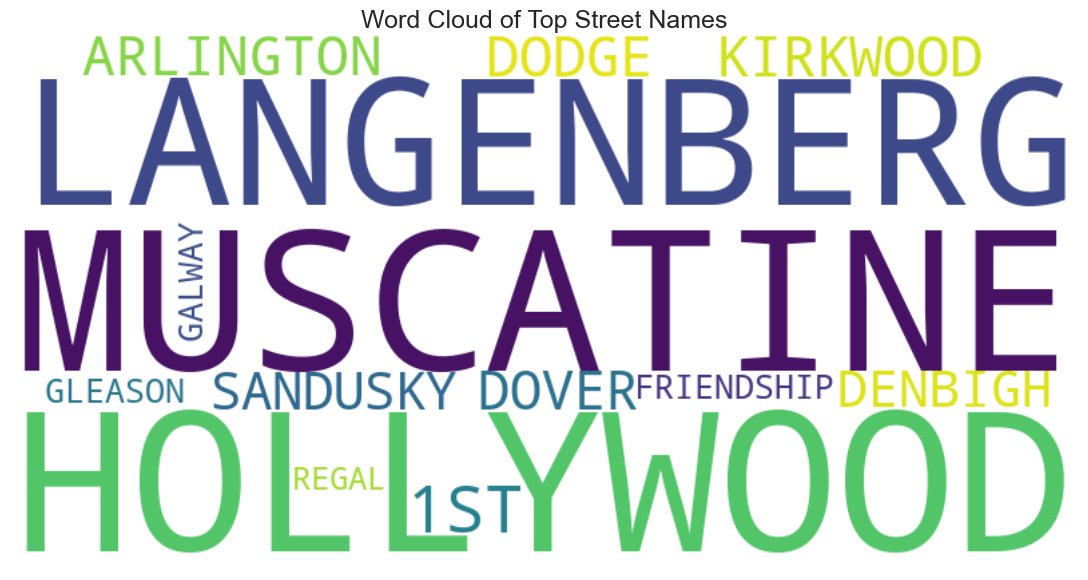

In [35]:
# 1. Load data
df = pd.read_csv('Combined, Cleaned Data/master_housing_plus_ACS.csv')

# 2. Extract the street portion before any comma (to drop city/state)
df['Street'] = df['Address'].astype(str).str.split(',', n=1).str[0]

# 3. Clean up 'Street'
#   a) Remove leading house numbers
df['Street'] = df['Street'].str.replace(r'^\d+\s+', '', regex=True)
#   b) Remove directionals (N, S, E, W, etc.)
df['Street'] = df['Street'].str.replace(r'^(N|S|E|W|NE|NW|SE|SW)\s+', '', regex=True, flags=re.IGNORECASE)
#   c) Strip common suffixes
suffix_pattern = (
    r'\b(?:st|street|ave|avenue|blvd|boulevard|dr|drive|rd|road|ln|lane|'
    r'ct|court|cir|circle|pl|place|ter|terrace|way|pkwy|parkway|hwy|highway)\b\.?'
)
df['Street'] = df['Street'].str.replace(suffix_pattern, '', regex=True, flags=re.IGNORECASE).str.strip()

# 4. Drop any residual "Iowa City" entries
df = df[~df['Street'].str.match(r'(?i)^iowa city$')]

# 5. Word cloud of those top streets
wordcloud = WordCloud(
    width=800, height=400, background_color='white',
    stopwords=STOPWORDS, 
    collocations=False
).generate_from_frequencies(top_streets.to_dict())

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top Street Names', fontsize=18)
plt.tight_layout()
plt.show()

/var/folders/bn/w71p881s2l37kwdsrn6n574c0000gn/T/ipykernel_26345/3283185682.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_streets.values, y=top_streets.index, palette='mako')


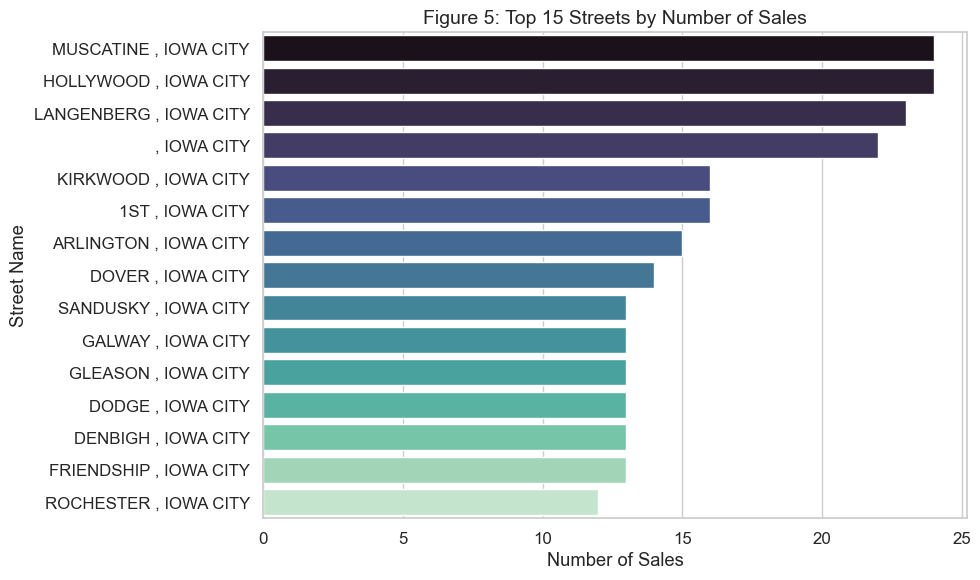

In [43]:
df = pd.read_csv('Combined, Cleaned Data/master_housing_plus_ACS.csv')

df['Street'] = (
    df['Address'].astype(str)
      .str.replace(r'^\d+\s+', '', regex=True)  # drop house numbers
      .str.replace(r'^(N|S|E|W|NE|NW|SE|SW)\s+', '', regex=True, flags=re.IGNORECASE)
      .str.replace(
          r'\b(?:st|street|ave|avenue|blvd|boulevard|dr|drive|rd|road|ln|lane|'
          r'ct|court|cir|circle|pl|place|ter|terrace|way|pkwy|parkway|hwy|highway)\b\.?',
          '',
          regex=True,
          flags=re.IGNORECASE
      )
      .str.strip()
)

# Remove any residual “Iowa City” entries
df = df[~df['Street'].str.match(r'(?i)^iowa city$')]

# 2. Compute top 15 streets by number of sales
top_streets = df['Street'].value_counts().nlargest(15)

# 3. Plot Figure 5: horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_streets.values, y=top_streets.index, palette='mako')
plt.title('Figure 5: Top 15 Streets by Number of Sales', fontsize=14)
plt.xlabel('Number of Sales')
plt.ylabel('Street Name')
plt.tight_layout()
plt.show()

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import r2_score, accuracy_score, f1_score

# Load data
DATA_FILE = 'Combined, Cleaned Data/master_housing_plus_ACS.csv'
df = pd.read_csv(DATA_FILE)

# Clean ALL numeric columns
num_cols = ['Sale Amount', 'Appraised Value', 'Total SF', 'Lot Area', 'Year Built']
for col in num_cols:
    df[col] = (
        df[col].astype(str)
             .str.replace(r'[\$,]', '', regex=True)  # strip $ and commas
             .str.replace(r'\*.*',   '',    regex=True)  # strip trailing flags
             .astype(float)
    )

# Prepare regression data
features = ['Total SF', 'Lot Area', 'Appraised Value', 'Year Built']
X = df[features].dropna()
y = df.loc[X.index, 'Sale Amount']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Run regression models
print("=== Regression Results (R²) ===")
regression_models = {
    'Linear'       : LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Lasso (α=0.1)': Lasso(alpha=0.1),
}
for name, model in regression_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"{name:15s} R² = {r2_score(y_test, preds):.3f}")

# Prepare classification data
median_price = df['Sale Amount'].median()
df['Above_Median'] = (df['Sale Amount'] > median_price).astype(int)
Xc = X  # same features as above
yc = df.loc[Xc.index, 'Above_Median']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, random_state=42
)

# Run classification models
print("\n=== Classification Results (Accuracy / F1) ===")
classification_models = {
    'Logistic' : LogisticRegression(max_iter=1000),
    'DecisionTree' : DecisionTreeClassifier(max_depth=5, random_state=42),
    'KNN (k=5)'    : KNeighborsClassifier(n_neighbors=5),
    'SVM (RBF)'    : SVC(kernel='rbf', random_state=42)
}
for name, clf in classification_models.items():
    clf.fit(Xc_train, yc_train)
    preds = clf.predict(Xc_test)
    print(f"{name:15s} Acc = {accuracy_score(yc_test, preds):.3f} | F1 = {f1_score(yc_test, preds):.3f}")


=== Regression Results (R²) ===
Linear          R² = 0.742
Ridge (α=1.0)   R² = 0.742
Lasso (α=0.1)   R² = 0.742

=== Classification Results (Accuracy / F1) ===
Logistic        Acc = 0.846 | F1 = 0.848
DecisionTree    Acc = 0.826 | F1 = 0.830
KNN (k=5)       Acc = 0.821 | F1 = 0.827
SVM (RBF)       Acc = 0.846 | F1 = 0.847


In [38]:
for name, model in regression_models.items():
    model.fit(X_train, y_train)
    print(f"\n{name} coefficients:")
    print(pd.Series(model.coef_, index=X.columns))


Linear coefficients:
Total SF          -11.975161
Lot Area            0.946318
Appraised Value     0.758353
Year Built         53.030073
dtype: float64

Ridge (α=1.0) coefficients:
Total SF          -11.975161
Lot Area            0.946318
Appraised Value     0.758353
Year Built         53.030038
dtype: float64

Lasso (α=0.1) coefficients:
Total SF          -11.975161
Lot Area            0.946318
Appraised Value     0.758353
Year Built         53.029979
dtype: float64


In [40]:
from scipy.stats import ttest_ind
sale_2013 = df[df.Year==2013]['Sale Amount']
sale_2023 = df[df.Year==2023]['Sale Amount']
t_stat, p_val = ttest_ind(sale_2023, sale_2013, equal_var=False)
print("T-test 2023 vs 2013: t =", round(t_stat,2), "p =", round(p_val,4))

T-test 2023 vs 2013: t = 13.35 p = 0.0


/var/folders/bn/w71p881s2l37kwdsrn6n574c0000gn/T/ipykernel_26345/3945261639.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


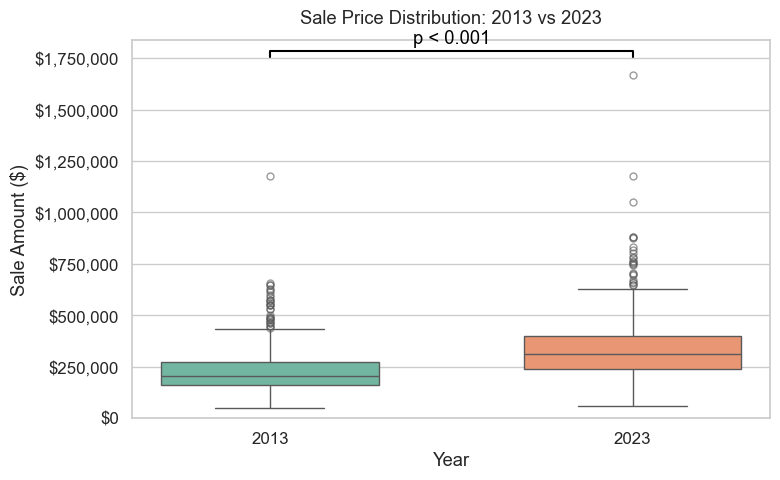

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from matplotlib import ticker

# Assume df is already loaded & cleaned
sale_2013 = df[df['Year']==2013]['Sale Amount']
sale_2023 = df[df['Year']==2023]['Sale Amount']
t_stat, p_val = ttest_ind(sale_2023, sale_2013, equal_var=False)

# Boxplot
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(
    x='Year',
    y='Sale Amount',
    data=df[df.Year.isin([2013,2023])],
    palette=['#66c2a5','#fc8d62'],
    width=0.6,
    showfliers=True,
    flierprops={'marker':'o','alpha':0.6,'markersize':5},
    ax=ax
)

# Formatting
ax.set_title('Sale Price Distribution: 2013 vs 2023', pad=12)
ax.set_ylabel('Sale Amount ($)')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Draw and annotate bracket
y_max = df['Sale Amount'].max()
y    = y_max * 1.05
h    = y_max * 0.02
x1, x2 = 0, 1
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
ax.text((x1+x2)/2, y + h*1.5, 'p < 0.001',
        ha='center', va='bottom', color='k')

# Bump y‑limit so the bracket and outliers fit
ax.set_ylim(0, y_max * 1.1)

plt.tight_layout()
plt.show()
